**Land Cover Classification using CNN**

In [ ]:
#Loading dataset
import zipfile
import os

# Path to the zip file
zip_path = "/content/EuroSAT.zip"
extract_path = "/content/EuroSAT"

# Check if the file exists
if os.path.exists(zip_path):
    # Unzipping the file
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"Files successfully extracted to: {extract_path}")
    except zipfile.BadZipFile:
        print("Error: The file is not a valid zip file.")
else:
    print("Error: Zip file not found.")

# List the contents of the extracted directory to verify
extracted_contents = os.listdir(extract_path) if os.path.exists(extract_path) else []
print("Extracted contents:", extracted_contents)

Files successfully extracted to: /content/EuroSAT
Extracted contents: ['EuroSAT']


In [ ]:
#Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
#Set Configuration
input_folder = "/content/EuroSAT/EuroSAT/"
train_df = "/content/EuroSAT/EuroSAT/train.csv"
val_df = "/content/EuroSAT/EuroSAT/validation.csv"
test_df = "/content/EuroSAT/EuroSAT/test.csv"
image_folder = "/content/EuroSAT/EuroSAT"
model_save_path = "/content/WorkingLog/"
tensorboard_logs_path = "/content/WorkingLog/"
figure_save_path = "/content/WorkingLog/"

batch_size = 32
img_size = (64, 64)
buffer_size = 100
learning_rate = 0.0001
input_shape = (64, 64, 3)
num_classes = 10
epochs = 100

In [ ]:
#Data Augmentation
def load_data(csv_path, image_folder, batch_size, img_size, buffer_size, shuffle):
    df = pd.read_csv(csv_path)
    image_paths = [f"{image_folder}/{filename}" for filename in df.Filename]
    labels = df.Label.values

    def load_image(image_path, label):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, img_size)
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        return tf.cast(image, tf.float32) / 255.0, label

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True)
    return dataset.batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset = load_data(train_df, image_folder, batch_size, img_size, buffer_size, True)
val_dataset = load_data(val_df, image_folder, batch_size, img_size, buffer_size, False)
test_dataset = load_data(test_df, image_folder, batch_size, img_size, buffer_size, False)

In [ ]:
#Define a CNN model
#input layer
inputs = tf.keras.layers.Input((64, 64, 3))

#Hidden layers
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(inputs)
x = tf.keras.layers.MaxPooling2D((2,2))(x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.3) (x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.3) (x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)

x = tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
#output layer
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [ ]:
#Display model architecture
model.summary()

In [ ]:
#Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#Define callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, verbose=1, mode='min', restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_save_path + 'best_model.weights.h5', monitor='val_loss', mode='min', save_weights_only=True,save_best_only=True, verbose=1)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_logs_path, histogram_freq=1, write_graph=True, write_images=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)
callbacks = [early_stop, checkpoint, tensorboard, lr_scheduler]

In [ ]:
#Train the model and record training time
%%time
import time
start_time = time.time()
history = model.fit(train_dataset,epochs=epochs,batch_size=64,validation_data=val_dataset,callbacks=callbacks)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Epoch 1/100
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1704 - loss: 2.0662
Epoch 1: val_loss improved from inf to 1.47084, saving model to /content/WorkingLog/best_model.weights.h5
591/591 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.1706 - loss: 2.0658 - val_accuracy: 0.4026 - val_loss: 1.4708 - learning_rate: 1.0000e-04
Epoch 2/100
587/591 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4585 - loss: 1.3490
Epoch 2: val_loss improved from 1.47084 to 1.16570, saving model to /content/WorkingLog/best_model.weights.h5
591/591 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.4588 - loss: 1.3486 - val_accuracy: 0.5433 - val_loss: 1.1657 - learning_rate: 1.0000e-04
Epoch 3/100
584/591 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5433 - loss: 1.1817
Epoch 3: val_loss improved from 1.16570 to 1.07307, saving model to /content/WorkingLog/best_model.weights.h5
591/591 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.5434 - loss: 1.1814 - val_accuracy: 0.5954 - val_loss: 1.0731

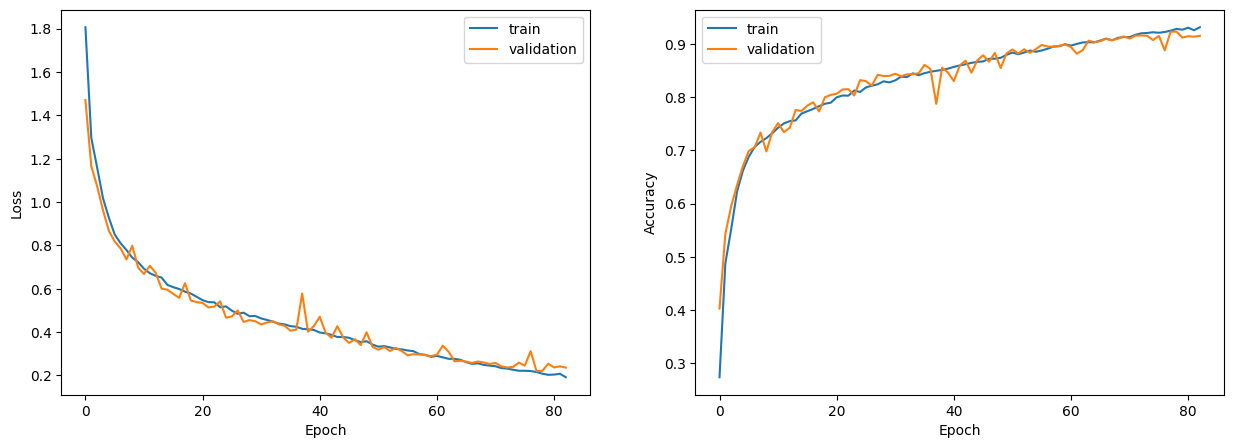

In [ ]:
#plot train and validation Loss and Accuracy
import matplotlib.pyplot as plt
# Plotting training history
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
#Load the saved model
model.load_weights("/content/WorkingLog/best_model.weights.h5")

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import tensorflow as tf

def one_hot_labels(dataset):
    return dataset.map(lambda x, y: (x, tf.one_hot(y, depth=10)))

train_dataset = one_hot_labels(train_dataset)
val_dataset = one_hot_labels(val_dataset)
test_dataset_1 = one_hot_labels(test_dataset)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Compute train, validation and test loss
train_loss, train_acc = model.evaluate(train_dataset)
print(f"train_loss:{train_loss:.3f}:: train_accuracy: {train_acc:.3f}")

val_loss, val_acc = model.evaluate(val_dataset)
print(f"val_loss:{val_loss:.3f}:: val_acc: {val_acc:.3f}")

test_loss, test_acc = model.evaluate(test_dataset_1)
print(f"test_loss:{test_loss:.3f}:: test_acc: {test_acc:.3f}")

591/591 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9346 - loss: 0.1844
train_loss:0.179:: train_accuracy: 0.938
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9253 - loss: 0.2151
val_loss:0.217:: val_acc: 0.923
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9097 - loss: 0.2476
test_loss:0.237:: test_acc: 0.912


In [ ]:
class_names = ["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial",
               "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"]


In [ ]:
#Make predictions
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


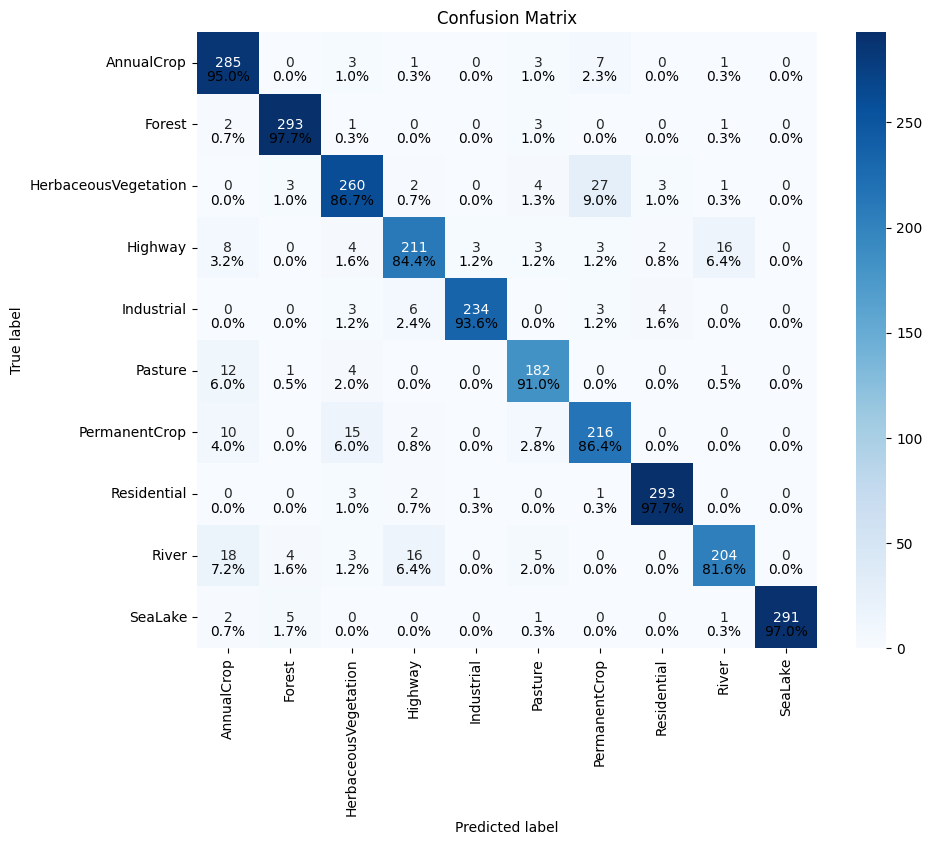

In [ ]:
#Compute and plot confusion matrix
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
#cm = multilabel_confusion_matrix(true_labels, predicted_labels)
import seaborn as sns
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j+0.5, i+0.6, f'\n{cm_percent[i, j]:.1f}%',
                 ha='center', va='center')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(true_labels)
y_test = lb.transform(true_labels)
y_pred = lb.transform(predicted_labels)

ROC AUC Score: 0.9507


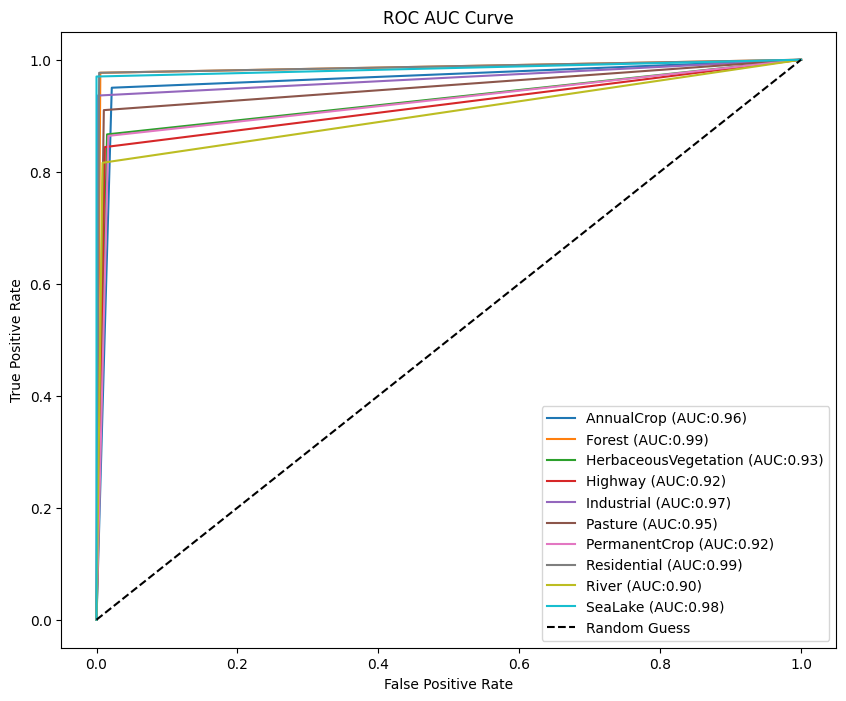

In [ ]:
#Plot ROC Curve
plt.figure(figsize=(10, 8))
for (idx, c_label) in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
    plt.plot(fpr, tpr, label=f'{c_label} (AUC:{auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend()
plt.savefig(f"{figure_save_path}roc_auc_curve.png")

print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred, average='macro'):.4f}")

In [ ]:
#Display Classification report
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels, target_names=class_names))

                      precision    recall  f1-score   support

          AnnualCrop       0.85      0.95      0.89       300
              Forest       0.96      0.98      0.97       300
HerbaceousVegetation       0.88      0.87      0.87       300
             Highway       0.88      0.84      0.86       250
          Industrial       0.98      0.94      0.96       250
             Pasture       0.88      0.91      0.89       200
       PermanentCrop       0.84      0.86      0.85       250
         Residential       0.97      0.98      0.97       300
               River       0.91      0.82      0.86       250
             SeaLake       1.00      0.97      0.98       300

            accuracy                           0.91      2700
           macro avg       0.91      0.91      0.91      2700
        weighted avg       0.92      0.91      0.91      2700

